## Crawling the data

In [ ]:
import spotipy
import conf
import re
import os
import editdistance
import io
import pandas as pd
import requests
from lyricsgenius import Genius
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import util
from pprint import pprint
from io import BytesIO
from PIL import Image
from bs4 import BeautifulSoup



cid = 'CID'
secret = 'SECRET_KEY'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
g_token = 'GENIUS_KEY'
genius = Genius(g_token)

In [ ]:
strings = []
for file in file_list:
    with open(file, encoding='utf-8') as f:
        html = f.read()
    soup = BeautifulSoup (html, 'html.parser')
    singles = soup.findAll('div', class_=re.compile('page_charts_section_charts_item_info'))
    for single in singles:
        try:
            title = single.find('a', class_='page_charts_section_charts_item_link release').text[2:-2]
            all_artists = single.find_all('a', class_='artist')
            artists = []
            for artist in all_artists[::-1]:
                artist = artist.text[2:-2]
                if artist.endswith('&') or artist.endswith(' /'):
                    artist = artist[:-2]
                artists.append(artist)
            genres = []
            for genre in single.find_all('a', class_='genre comma_separated'):
                genres.append(genre.text)
            descriptors = []
            for desc in single.find('div', class_='page_charts_section_charts_item_genre_descriptors'):
                if desc.text != '\n':
                    descriptors.append(desc.text)
            user_score = float(single.find('span', class_='stat page_charts_section_charts_item_details_average_num').text)
            query = artist + ' ' + title
            print('Кажется, это ', query, '. Пробую найти информацию на Genius.', sep='')
            candidates = genius.search_songs(query)
            if len(artists) > 1:
                add_artist = ' & '.join(artists)
                query = add_artist + ' ' + title
                candidates['hits'].extend(genius.search_songs(query)['hits'])
                if '/' in title:
                    alt_title = title.split(' / ')[0]
                    query = add_artist + ' ' + alt_title
                    candidates['hits'].extend(genius.search_songs(query)['hits'])
            if '/' in title:
                alt_title = title.split(' / ')[0]
                query = artist + ' ' + alt_title
                candidates['hits'].extend(genius.search_songs(query)['hits'])
            counter = {}
            for c in candidates['hits']:
                q = c['result']['artist_names'] + ' ' + c['result']['title']
                edit_distance = editdistance.eval(query.lower(), q.lower())
                counter.update({c['result']['id']: edit_distance})
            best_choice = min(counter, key=counter.get)
            song = genius.song(best_choice)
            lyrics = genius.lyrics(best_choice)
            if lyrics != None or len(lyrics) >=40:
                lyrics = re.sub('(?:[0-9]+|)Embed.*', '', lyrics)
                lyrics = re.sub('.+Lyrics\[', '[', lyrics)
                link = 'https://genius.com/songs/' + str(best_choice)
                response = requests.get(link)
                response = requests.get(response.url)
                if response.status_code == 200:
                    soup = BeautifulSoup (response.text, 'html.parser')
                    genre_tags = soup.findAll('a', class_=re.compile('SongTags__+'))
                    for tag in genre_tags:
                        tag = tag.text
                        cond = True
                        for genre in genres:
                            if editdistance.eval(genre.lower(), tag.lower()) <= 1:
                                cond = False
                        if cond:
                            repl = {'Synth-Pop': 'Synthpop', 
                                    'Electro-Pop': 'Electropop',
                                    'Alternative Pop': 'Alt-Pop'}
                            if tag in repl:
                                tag = repl[tag]
                            genres.append(tag)
                year = song['song']['release_date'][:4]
                results = sp.search(q=song['song']['artist_names'].replace(' &', '') + ' ' + song['song']['title'], 
                                    type='track')
                track_id = results['tracks']['items'][0]['id']
                af = sp.audio_features(track_id)
                valence = af[0]['valence']
                speechiness = af[0]['speechiness']
                acousticness = af[0]['acousticness']
                energy = af[0]['energy']
                tempo = af[0]['tempo']
                loudness = af[0]['loudness']
                danceability = af[0]['danceability']
                string = [title, artist, lyrics, year, user_score, genres, descriptors, valence, speechiness, 
                          acousticness, energy, tempo, loudness, danceability]
                strings.append(string)
                print(year)
                print(genres)
        except:
            pass

In [220]:
df

,title,artist,lyrics,year,user_score,genres,descriptors,valence,speechiness,acousticness,energy,tempo,loudness,danceability
0,Girls Just Want to Have Fun,Bladee,"[Verse 1: Bladee]\nTouch, unite\nOut of this w...",2020,3.91,"[Synthpop, Dance-Pop, Chillwave, Ambient Pop, ...","[androgynous vocals, ethereal, uplifting, soot...",0.1300,0.0365,0.01880,0.632,149.911,-8.207,0.517
1,Forever,Charli XCX,[Verse 1]\nLove suicide\nYou and I drove for m...,2020,4.06,"[Electropop, Glitch Pop, Hyperpop, Bubblegum B...","[noisy, romantic, love, bittersweet, sentiment...",0.4620,0.1070,0.57800,0.927,87.389,-3.195,0.577
2,My Rajneesh,Sufjan Stevens,"My Rajneesh LyricsAfter the storm, we shaved o...",2020,4.03,"[Progressive Pop, Indietronica, Art Pop, Chamb...","[epic, progressive, lush, dense, religious, ma...",0.1810,0.0453,0.92400,0.525,124.020,-10.844,0.303
3,Good Ones,Charli XCX,[Verse 1]\nI wish you gave me a reason\nThat y...,2021,3.31,"[Dance-Pop, Electropop, Synthwave, Electroclas...","[female vocals, breakup, rhythmic, love, party...",0.7890,0.0293,0.07200,0.672,129.049,-5.947,0.764
4,The Princess and the Clock,Kero Kero Bonito,"[Chorus]\nOh, ooh, oh\nHigh up in a chamber\nS...",2021,3.95,"[Electropop, Synthpop, Bitpop, Indietronica, E...","[fairy tale, female vocals, uplifting, fantasy...",0.4500,0.0350,0.05710,0.838,144.958,-5.249,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,I Don't Want It at All,Kim Petras,[Chorus]\nI want all my clothes designer (Ooh!...,2017,3.78,"[Dance-Pop, Synthpop, Nu-Disco, Synth Funk, Po...","[female vocals, boastful, energetic, melodic, ...",0.7720,0.0743,0.10100,0.729,110.020,-3.521,0.768
1043,Say You Will,Kanye West,[Verse 1]\nWhy would she make calls out the bl...,2008,4.02,"[Art Pop, Electropop, Ambient Pop, Choral, Tri...","[male vocals, breakup, female vocals, melodic,...",0.3470,0.0306,0.54200,0.401,172.633,-10.155,0.603
1044,Lark,Angel Olsen,[Verse 1]\nTo forget you is to hide\nThere is...,2019,3.95,"[Art Pop, Chamber Pop, Progressive Pop, Art Ro...","[epic, lush, suspenseful, introspective, femal...",0.0459,0.0314,0.00321,0.557,99.065,-8.367,0.445
1045,Cheap Thrills,Sia,"[Verse 1]\nCome on, come on, turn the radio on...",2016,2.60,"[Electropop, Dancehall, Dance-Pop, Moombahton,...","[tropical, energetic, optimistic, female vocal...",0.7320,0.1050,0.04720,0.698,89.976,-5.608,0.628


## Average values of audio features for each genre

In [276]:
strings = []
for genre in genres:
    danceability = genre['danceability'].mean()
    energy = genre['energy'].mean()
    speechiness = genre['speechiness'].mean()
    valence = genre['valence'].mean()
    acousticness = genre['acousticness'].mean()
    strings.append([genre_name, danceability, energy, speechiness, valence, acousticness])

average_features = pd.DataFrame(strings, 
                                columns = ['genre_name', 'danceability', 'energy', 'speechiness', 'valence', 'acousticness'])

In [277]:
average_features

,genre_name,danceability,energy,speechiness,valence,acousticness
0,Pop,"0,62","0,67","0,06","0,53","0,20"
1,Rock,"0,46","0,79","0,07","0,46","0,07"
2,Hip Hop,"0,73","0,69","0,23","0,54","0,15"
3,Blues,"0,60","0,57","0,09","0,46","0,44"
4,R&B,"0,66","0,58","0,10","0,52","0,25"
5,Country,"0,56","0,63","0,04","0,51","0,27"
6,Folk,"0,48","0,37","0,05","0,33","0,67"
7,Jazz,"0,53","0,43","0,17","0,37","0,44"


### Imports

In [ ]:
import pandas as pd

In [ ]:
songs = pd.read_csv(songs_path)

In [ ]:
albums = pd.read_csv(albums_path)

In [ ]:
# Загрузим жанры
import ast
  
with open(genres_path, 'r') as f:
    data = f.read()
      
genres = ast.literal_eval(data)
print(len(genres.keys()))

21


### Preprocessing data

In [ ]:
# Объединим фреймы для удобства работы
# Удалим ненужные столбцы
res = songs.merge(albums, left_on="release_id", right_on="album_id").drop(columns = ['song_id',	'title_x',	'release_id',	'position',	'released_x', 'mode',	'key',	'tempo',	'time_signature', 'album_id',	'title_y',	'record_type',	'record_label',	'critic_score',	'user_score',	'released_y'],axis = 1)

In [ ]:
res

,length,full_lyrics,emotion,spotify_danceability,spotify_energy,spotify_speechiness,spotify_valence,spotify_acousticness,spotify_loudness,genres,tags,artists
0,252,[Verse 1]\nIf you ever get close to a human\nA...,sad,0.681,0.650,0.0358,0.5080,0.03960,-14.637,"['Art Pop', 'House', 'Dance-Pop', 'Downtempo']","['passionate, romantic, female vocals, play...",['Björk']
1,290,[Verse 1]\nI travel all around the city\nGo in...,happy,0.658,0.678,0.0309,0.7020,0.00602,-11.123,"['Art Pop', 'House', 'Dance-Pop', 'Downtempo']","['passionate, romantic, female vocals, play...",['Björk']
2,283,[Verse 1]\nHis wicked sense of humour\nSuggest...,happy,0.617,0.393,0.0353,0.8400,0.03140,-11.767,"['Art Pop', 'House', 'Dance-Pop', 'Downtempo']","['passionate, romantic, female vocals, play...",['Björk']
3,202,"[Verse 1: Björk]\nCome on, girl\nLet's sneak o...",relaxed,0.731,0.500,0.0383,0.7060,0.06570,-12.953,"['Art Pop', 'House', 'Dance-Pop', 'Downtempo']","['passionate, romantic, female vocals, play...",['Björk']
4,273,[Verse 1]\nLately\nI find myself out gazing at...,relaxed,0.426,0.150,0.0369,0.0699,0.96500,-14.988,"['Art Pop', 'House', 'Dance-Pop', 'Downtempo']","['passionate, romantic, female vocals, play...",['Björk']
...,...,...,...,...,...,...,...,...,...,...,...,...
18989,259,[Verse 1]\nI can’t believe the things you said...,sad,0.480,0.560,0.0373,0.1670,0.15700,-5.196,"['Film Soundtrack', 'Contemporary Country', 'A...","['female vocals, male vocals, love, ballad,...","['Lady Gaga', 'Bradley Cooper']"
18990,0,[Verse]\nPlease don't tell me I'm too far gone...,sad,0.000,0.000,0.0000,0.0000,0.00000,0.000,"['Film Soundtrack', 'Contemporary Country', 'A...","['female vocals, male vocals, love, ballad,...","['Lady Gaga', 'Bradley Cooper']"
18991,0,[Bobby]\nJack talked about how music is essent...,sad,0.000,0.000,0.0000,0.0000,0.00000,0.000,"['Film Soundtrack', 'Contemporary Country', 'A...","['female vocals, male vocals, love, ballad,...","['Lady Gaga', 'Bradley Cooper']"
18992,281,[Verse 1: Lady Gaga]\nWish I could\nI could ha...,sad,0.451,0.340,0.0310,0.2210,0.76300,-7.466,"['Film Soundtrack', 'Contemporary Country', 'A...","['female vocals, male vocals, love, ballad,...","['Lady Gaga', 'Bradley Cooper']"


In [ ]:
# Проверим, что осталось
res.columns

Index(['length', 'full_lyrics', 'emotion', 'spotify_danceability',
       'spotify_energy', 'spotify_speechiness', 'spotify_valence',
       'spotify_acousticness', 'spotify_loudness', 'genres', 'tags',
       'artists'],
      dtype='object')

In [ ]:
# Очистим наш фрейм от пустых мест
res.rename(columns={'full_lyrics': 'text'}, inplace=True)
res = res[res['text' or 'genres'].notnull()]

In [ ]:
# Нужно преобразовать str в list
print(type(res['genres'][0]))

<class 'str'>


In [ ]:
# Функция преобразования str в list
# В нашем файле присутствуют пустые строки, вернем None вместо них
# При изменении жанра мы пройдемся по всем элементам словаря и найдем наш жанр из списка, заменим на более общий
from ast import literal_eval

stop_genres = ['Field Recordings', 'Musical Theatre and Entertainment', 'Classical Music', 'Dance', 'Electronic', 'Psychedelia', 'Experimental', 'Industrial Music']

def transform(x: str) -> list:
  x = literal_eval(x)
  if x:
    # Заменим более общим жанром
    for num, j in enumerate(x):
      for i in genres:
        if j in genres[i]:
          x[num] = i
    x = [genre for genre in x if genre in genres.keys() and genre not in stop_genres]
    if 0 < len(set(x)) < 3 :
      return list(set(x))
    else:
      return None
  else:
    return None

In [ ]:
res['genres'] = res['genres'].apply(lambda x: transform(x))
res = res[res['genres'].notnull()]
res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,length,text,emotion,spotify_danceability,spotify_energy,spotify_speechiness,spotify_valence,spotify_acousticness,spotify_loudness,genres,tags,artists
0,252,[Verse 1]\nIf you ever get close to a human\nA...,sad,0.681,0.650,0.0358,0.5080,0.03960,-14.637,Pop,"['passionate, romantic, female vocals, play...",['Björk']
1,290,[Verse 1]\nI travel all around the city\nGo in...,happy,0.658,0.678,0.0309,0.7020,0.00602,-11.123,Pop,"['passionate, romantic, female vocals, play...",['Björk']
2,283,[Verse 1]\nHis wicked sense of humour\nSuggest...,happy,0.617,0.393,0.0353,0.8400,0.03140,-11.767,Pop,"['passionate, romantic, female vocals, play...",['Björk']
3,202,"[Verse 1: Björk]\nCome on, girl\nLet's sneak o...",relaxed,0.731,0.500,0.0383,0.7060,0.06570,-12.953,Pop,"['passionate, romantic, female vocals, play...",['Björk']
4,273,[Verse 1]\nLately\nI find myself out gazing at...,relaxed,0.426,0.150,0.0369,0.0699,0.96500,-14.988,Pop,"['passionate, romantic, female vocals, play...",['Björk']
...,...,...,...,...,...,...,...,...,...,...,...,...
18959,201,"[Produced By Anthony Kilhoffer, Kanye West & M...",angry,0.480,0.808,0.0423,0.3700,0.02590,-4.133,Hip Hop,"['boastful, male vocals, sampling, urban, ...","['Jay-Z', 'Kanye West']"
18960,0,[Three minutes of silence]\n\n[Intro: Kanye We...,sad,0.000,0.000,0.0000,0.0000,0.00000,0.000,Hip Hop,"['boastful, male vocals, sampling, urban, ...","['Jay-Z', 'Kanye West']"
18961,189,[Verse 1: Kanye West]\nIt was all good just a ...,happy,0.801,0.771,0.3030,0.7610,0.26800,-6.418,Hip Hop,"['boastful, male vocals, sampling, urban, ...","['Jay-Z', 'Kanye West']"
18962,199,[Produced by No I.D.]\n\n[Intro: Jay Z]\nWe in...,angry,0.662,0.923,0.2100,0.4700,0.16600,-4.085,Hip Hop,"['boastful, male vocals, sampling, urban, ...","['Jay-Z', 'Kanye West']"


In [ ]:
# Выбросим те песни, у которых нет метаданных
for i in ['spotify_danceability',	'spotify_energy',	'spotify_speechiness',	'spotify_valence',	'spotify_acousticness',	'spotify_loudness']:
  res = res[res[i] != 0]

## Sampling

C:\Program Files\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

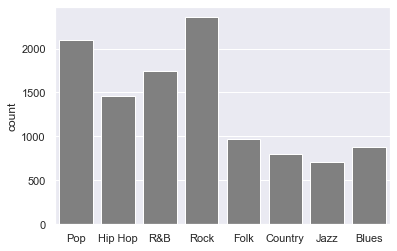

In [11]:
import seaborn as sns
sns.set()

sns.countplot(res['genres'], color='gray')

In [ ]:
import numpy as np

# ограничение в 1200 - среднее число
num_songs = 1200
df = pd.DataFrame()

for i in res['genres'].unique():
  add = res[res['genres'] == i][:num_songs]
  num = int(num_songs / add.shape[0])
  add = pd.DataFrame(np.repeat(add.values, num, axis=0), columns=add.columns).astype(add.dtypes)
  df = df.append(add)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


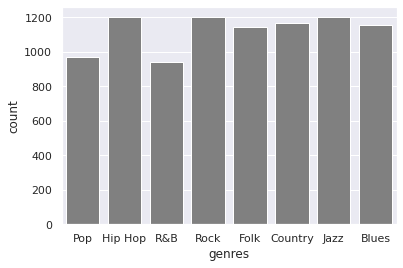

In [ ]:
import seaborn as sns
sns.set()

sns.countplot(df['genres'], color='gray')

In [ ]:
for i in range(0,5):
  df = df.sample(frac=1)

In [ ]:
genres_res = set()
for i in df['genres']:
  k = set(i)
  for j in k:
    genres_res.add(j)

In [ ]:
res = df

In [ ]:

num = [x for x in range(0, len(res['genres'].unique()))]
genres_with_num = dict(zip(res['genres'].unique(), num))


print(genres_with_num)
res['genres_code'] = res['genres']
res['genres_code'] = res['genres_code'].apply(lambda x: int(genres_with_num[x]))
res = res[res['genres_code'].notnull()]
res

## Text preprocessing

Без лемматизации

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
cleaned = res.copy()


cleaned['text'] = cleaned['text'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')
cleaned['text'] = cleaned['text'].str.replace("\[(.*?)\]", ' ')
cleaned['text'] = cleaned['text'].str.replace("' | '", ' ')
cleaned['text'] = cleaned['text'].str.replace('x[0-9]+', ' ')
cleaned = cleaned[~cleaned['text'].str.contains(r'[^\x00-\x7F]+')]
cleaned = cleaned[cleaned['text'].str.strip() != '']


cleaned.reset_index(inplace = True)

from nltk.corpus import stopwords
stop = stopwords.words('english')

cleaned['text'] = cleaned['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Без лемматизации
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text, flg_lemm=True):
    lst_text = text.split()
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)
    return text

#cleaned["text"]  = cleaned["text"].apply(lambda x:  lemmatize_text(x))

## Splitting Data into training and test set multiclass

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
cleaned = cleaned.sample(frac=1)
df_train, df_test = train_test_split(cleaned, test_size=0.2, random_state=10, stratify=cleaned["genres_code"].values)

In [ ]:
NUM_OF_CAT = len(cleaned['genres_code'].unique())

In [ ]:
df_train.reset_index() 
df_test.reset_index() 

In [ ]:
#train_test split
x_tr, y_tre = df_train['text'].values, df_train['genres_code'].values
x_val, y_vali = df_test['text'].values, df_test['genres_code'].values

In [ ]:
from keras.utils import np_utils
from numpy import array

y_tre = np.array(y_tre.reshape(len(y_tre), ))
y_vali = np.array(y_vali.reshape(len(y_vali), ))
# One-hot encoding
y_tr = np_utils.to_categorical(y_tre, num_classes=NUM_OF_CAT)
y_val = np_utils.to_categorical(y_vali, num_classes=NUM_OF_CAT)

## Splitting Data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
cleaned = cleaned.sample(frac=1)
df_train, df_test = train_test_split(cleaned, test_size=0.2, random_state=10, stratify=cleaned["genres_code"].values)

In [ ]:
NUM_OF_CAT = len(genres_with_num)

In [ ]:
df_train.reset_index() 
df_test.reset_index() 

,level_0,index,length,text,emotion,spotify_danceability,spotify_energy,spotify_speechiness,spotify_valence,spotify_acousticness,spotify_loudness,genres,tags,artists,names,genres_code
0,1084,2042,192,Selena Gomez If I give every piece I know coul...,relaxed,0.695,0.573,0.1670,0.380,0.132,-8.882,"[R&B, Pop]","['breakup, melodic, bittersweet, female voc...",['Selena Gomez'],Selena Gomez,"[7, 5]"
1,649,1260,213,Shawn Mendes Taste poison lips Lately we're go...,sad,0.361,0.311,0.0369,0.323,0.872,-11.748,"[R&B, Pop]","['male vocals, love, lush, melodic, warm, ...",['Shawn Mendes'],Shawn Mendes,"[7, 5]"
2,8856,16297,183,Bob Dylan That old black magic weaved spell Th...,relaxed,0.723,0.289,0.0974,0.607,0.592,-20.219,"[Pop, Jazz]","['love, mellow, longing, romantic, male vo...",['Bob Dylan'],Bob Dylan,"[5, 2]"
3,4935,9638,199,Lionel Richie Forever ever ever ever ever And ...,happy,0.628,0.791,0.0606,0.597,0.330,-6.278,"[R&B, Pop]",['male vocals'],['Lionel Richie'],Lionel Richie,"[7, 5]"
4,3175,6632,52,Dr Dre Damn girl hotter motherfucker You got r...,happy,0.756,0.732,0.1230,0.689,0.142,-12.101,[Hip Hop],"['drugs, sexual, crime, male vocals, vulga...",['Dr. Dre'],Dr. Dre,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,4857,9445,173,John Lennon Well I Meat City see Well I Meat C...,angry,0.474,0.920,0.0567,0.571,0.110,-8.818,[Rock],"['melodic, male vocals, conscious, upliftin...",['John Lennon'],John Lennon,[6]
2069,8696,15888,282,Aretha Franklin At dark end street That's alwa...,sad,0.387,0.378,0.0343,0.333,0.569,-11.714,[R&B],['female vocals'],['Aretha Franklin'],Aretha Franklin,[7]
2070,10250,18753,215,Carly Rae Jepsen Sunshine shoulders makes happ...,relaxed,0.705,0.609,0.0250,0.601,0.169,-7.542,[Pop],"['happy, soft, love, summer, melodic, ene...",['Carly Rae Jepsen'],Carly Rae Jepsen,[5]
2071,5036,9756,257,Billy Joel Hey Lord take look around And I'd f...,happy,0.508,0.775,0.0422,0.850,0.104,-9.002,[Rock],"['love, uplifting, romantic, sentimental, ...",['Billy Joel'],Billy Joel,[6]


In [ ]:
#train_test split
x_tr, y_tre = df_train['text'].values, df_train['genres_code'].values
x_val, y_vali = df_test['text'].values, df_test['genres_code'].values

## Max length of the sequence in the corpus

In [ ]:
maximumlen = res['length'].max()

## Tokenization and Padding of the sequences to make their length same

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(x_tr))

x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

x_tr_seq  = pad_sequences(x_tr_seq, maxlen=maximumlen)
x_val_seq = pad_sequences(x_val_seq, maxlen=maximumlen)

## Loading Pretrained Glove Word Embedding

In [ ]:
#!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

In [ ]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
import numpy as np
embeddings_index = dict()
f = open('./glove.840B.300d.txt')
try:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
except:
  print(values[1])
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

.
Loaded 52343 word vectors.


In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

31821


## Creating a weight matrix

In [ ]:
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Metrics

Зададим нашу собственную F1 метрику

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [ ]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        # return lr * tf.math.exp(-0.1)
        return lr - 0.00003
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6)  
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def threshold_binary_accuracy(y_true, y_pred):
    threshold = 0.80
    return K.mean(K.equal(y_true, K.tf.cast(K.lesser(y_pred,threshold), y_true.dtype)))

## Облегчённая LSTM Model

Создаем простую LSTM модель для проверки размера батча

In [ ]:
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

Воспользуемся формулой Nh ~= 2/3*(Ni+No), где:
* Nh - количество скрытых слоев
* Ni - количество входных нейронов
* No - количество выходных нейронов

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import regularizers

model=Sequential()

#Embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

#Lstm layer
model.add(Bidirectional(LSTM(256,return_sequences=True,dropout=0.05, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l1(1e-5))))
#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense layer
model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-5)))
# softmax
model.add(Dense(NUM_OF_CAT,activation='softmax')) 

In [ ]:
# Проведём тесты для различных lr
lr = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
all = []
for num, learning_rate in enumerate(lr):
  model=Sequential()
  #Embedding layer
  model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

  #LSTM layer
  model.add(Bidirectional(LSTM(256,return_sequences=True,dropout=0.05, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l1(1e-5))))
  #Global Maxpooling
  model.add(GlobalMaxPooling1D())

  #Dense Layer
  model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-5)))
  
  model.add(Dense(NUM_OF_CAT,activation='softmax')) 
  optimizer = keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
    
  #print(model.summary())
  history = model.fit( np.array(x_tr_seq), np.array(y_tr), batch_size=128, shuffle=True, epochs=40,callbacks=[es], validation_data=(np.array(x_val_seq),np.array(y_val)))
  all.append(history)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/44 [==============================] - 143s 2s/step - loss: 2.4286 - acc: 0.2372 - f1: 0.0000e+00 - val_loss: 2.3733 - val_acc: 0.4055 - val_f1: 0.0000e+00
Epoch 2/40
44/44 [==============================] - 69s 2s/step - loss: 2.3217 - acc: 0.4146 - f1: 0.0000e+00 - val_loss: 2.2546 - val_acc: 0.4747 - val_f1: 0.0000e+00
Epoch 3/40
44/44 [==============================] - 69s 2s/step - loss: 2.1762 - acc: 0.4651 - f1: 0.0090 - val_loss: 2.0639 - val_acc: 0.4830 - val_f1: 0.0531
Epoch 4/40
44/44 [==============================] - 69s 2s/step - loss: 1.9706 - acc: 0.4909 - f1: 0.1557 - val_loss: 1.8660 - val_acc: 0.5220 - val_f1: 0.2366
Epoch 5/40
44/44 [==============================] - 69s 2s/step - loss: 1.8039 - acc: 0.5209 - f1: 0.2752 - val_loss: 1.7526 - val_acc: 0.5341 - val_f1: 0.3025
Epoch 6/40
44/44 [==============================] - 69s 2s/step - loss: 1.6907 - acc: 0.5504 - f1: 0.3461 - val_loss: 1.6384 - val_acc: 0.5907 - val_f1: 0.3810
Epoch 7/40
44/44 [================

### Show graphics of list learning rates

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']

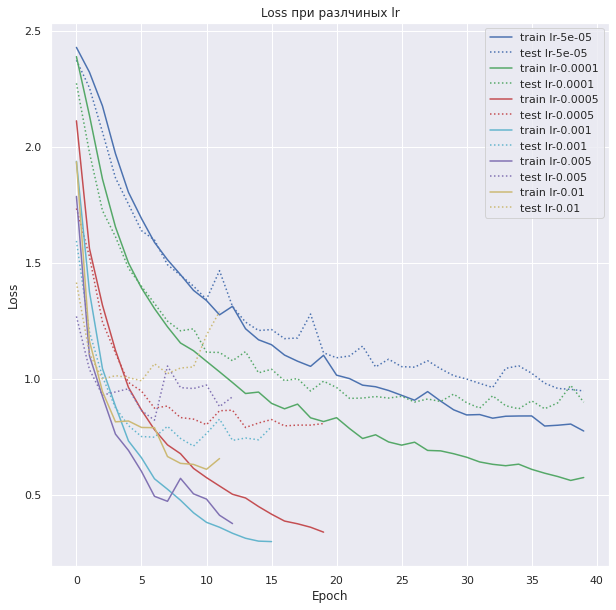

In [ ]:
# plot training history
plt.figure(figsize=(10,10))
for i, j, k in zip(to_file, colors, lr):
  plt.plot(i['loss'], label=f'train lr-{k}', color = j)
  plt.plot(i['val_loss'], label=f'test lr-{k}', linestyle = ':', color = j)

plt.title("Loss при разлчиных lr")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Из графика видно, что оптимальный lr - 0.0001

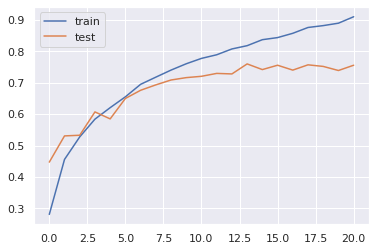

In [ ]:
# plot training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

## LSTM Model

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

Воспользуемся формулой Nh ~= 2/3*(Ni+No), где:
* Nh - Количество скрытых слоев
* Ni - количество входных нейронов
* No - количество выходных нейронов

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import regularizers

model=Sequential()

#Embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

#Lstm layer
model.add(Bidirectional(LSTM(256,return_sequences=True,dropout=0.05, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l1(1e-5))))
#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu', activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(NUM_OF_CAT,activation='softmax')) 

optimizer = keras.optimizers.Adam(lr=0.0001)
# В случае 'binary_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1077, 300)         7006800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1077, 512)        1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit( np.array(x_tr_seq), np.array(y_tr), batch_size=32, shuffle=True, epochs=40,callbacks=[lr_scheduler, es, mc], validation_data=(np.array(x_val_seq),np.array(y_val)))

Epoch 1/40
174/174 [==============================] - ETA: 0s - loss: 2.2779 - acc: 0.2807 - f1: 0.0499
Epoch 1: val_acc improved from -inf to 0.44710, saving model to best_model.h5
174/174 [==============================] - 117s 632ms/step - loss: 2.2779 - acc: 0.2807 - f1: 0.0499 - val_loss: 1.9992 - val_acc: 0.4471 - val_f1: 0.1302 - lr: 1.0000e-04
Epoch 2/40
174/174 [==============================] - ETA: 0s - loss: 1.8581 - acc: 0.4557 - f1: 0.2545
Epoch 2: val_acc improved from 0.44710 to 0.53065, saving model to best_model.h5
174/174 [==============================] - 109s 628ms/step - loss: 1.8581 - acc: 0.4557 - f1: 0.2545 - val_loss: 1.6802 - val_acc: 0.5306 - val_f1: 0.3927 - lr: 1.0000e-04
Epoch 3/40
174/174 [==============================] - ETA: 0s - loss: 1.6353 - acc: 0.5275 - f1: 0.4215
Epoch 3: val_acc improved from 0.53065 to 0.53275, saving model to best_model.h5
174/174 [==============================] - 109s 628ms/step - loss: 1.6353 - acc: 0.5275 - f1: 0.4215 - v

### Show graphics of model

In [ ]:
from matplotlib import pyplot as plt

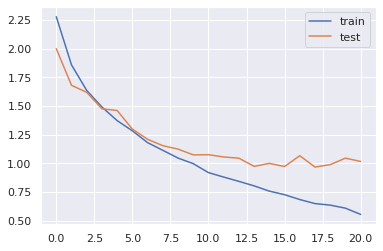

In [ ]:
# plot training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

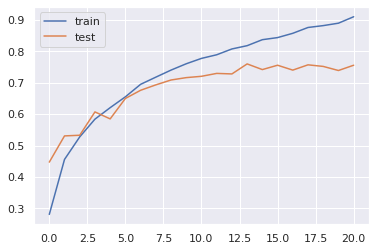

In [ ]:
# plot training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Confusion matrix of model

В качестве метрики мы будем использовать f1-меру (F=2(Precision×Recall)/(Precision+Recall))

Метрика Accuracy (Accuracy=P/N, P - кол-во правильных ответов, N - всего в выборке) будет использоваться в качестве базовой, но не решающей.

In [ ]:
predicted = model.predict(np.array(x_val_seq),workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y_pred = np.argmax(predicted, axis=1)

In [ ]:
genres_with_num

{'Blues': 1,
 'Classical Music': 7,
 'Country': 4,
 'Dance': 2,
 'Folk': 3,
 'Hip Hop': 9,
 'Jazz': 6,
 'Pop': 5,
 'R&B': 0,
 'Rock': 8}

[[303   0   0   0  14   0   0   2]
 [ 20 112  60  43  45   8  11   3]
 [ 16  84 158  29  29   8   5   4]
 [  8  51  30 195  16  12   7  10]
 [ 26   3   0   3 234   0   0   0]
 [  1   5   4   8   1 217   0   2]
 [  0   0   0   0   0   0 322   0]
 [ 14   0   0   0   0   0   0 259]]


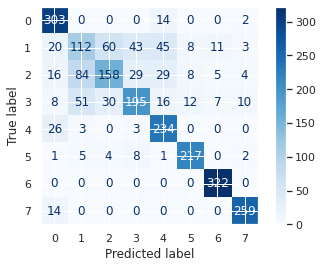

In [ ]:
cm = confusion_matrix(array(y_vali), array(y_pred))
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Second LSTM Model

### Model

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from keras.layers import Bidirectional

model=Sequential()

#Embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

#Lstm layer
model.add(Bidirectional(LSTM(512,return_sequences=True,dropout=0.05), bias_regularizer=regularizers.l1(1e-5)))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
# softmax
model.add(Dense(NUM_OF_CAT,activation='softmax')) 

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1077, 300)         6890700   
                                                                 
 bidirectional (Bidirectiona  (None, 1077, 1024)       3330048   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


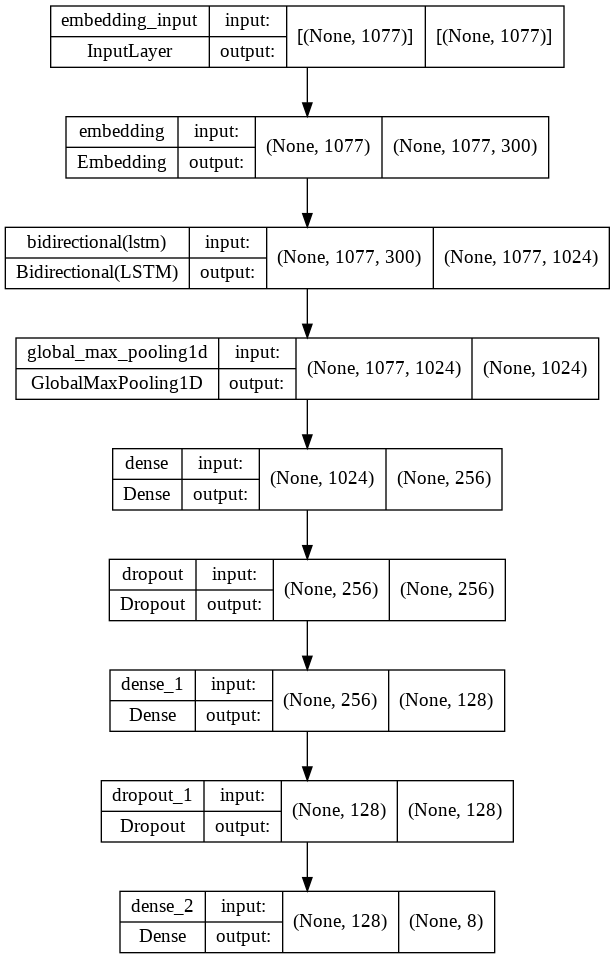

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.3)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit( np.array(x_tr_seq), np.array(y_tr), batch_size=32, shuffle=True, epochs=40,callbacks=[lr_scheduler, es, mc], validation_data=(np.array(x_val_seq),np.array(y_val)))

Epoch 1/40
199/199 [==============================] - ETA: 0s - loss: 1.7372 - acc: 0.3517 - f1: 0.1296
Epoch 1: val_acc improved from -inf to 0.54626, saving model to best_model.h5
199/199 [==============================] - 78s 353ms/step - loss: 1.7372 - acc: 0.3517 - f1: 0.1296 - val_loss: 1.2870 - val_acc: 0.5463 - val_f1: 0.3488 - lr: 1.0000e-04
Epoch 2/40
199/199 [==============================] - ETA: 0s - loss: 1.1298 - acc: 0.5992 - f1: 0.4901
Epoch 2: val_acc improved from 0.54626 to 0.66205, saving model to best_model.h5
199/199 [==============================] - 72s 362ms/step - loss: 1.1298 - acc: 0.5992 - f1: 0.4901 - val_loss: 0.9310 - val_acc: 0.6621 - val_f1: 0.6238 - lr: 1.0000e-04
Epoch 3/40
199/199 [==============================] - ETA: 0s - loss: 0.8858 - acc: 0.6807 - f1: 0.6317
Epoch 3: val_acc improved from 0.66205 to 0.75456, saving model to best_model.h5
199/199 [==============================] - 74s 374ms/step - loss: 0.8858 - acc: 0.6807 - f1: 0.6317 - val_

### Графики

In [ ]:
from matplotlib import pyplot as plt

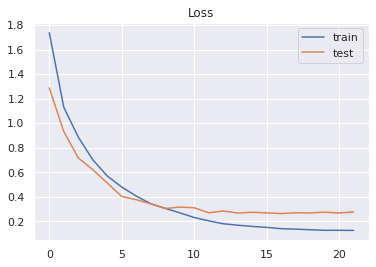

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()

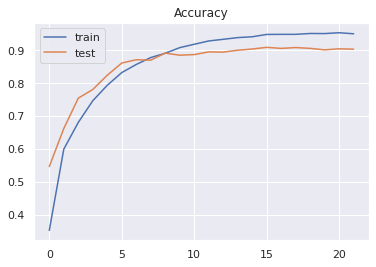

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

### Confusion matrix of model

In [ ]:
predicted = model.predict(np.array(x_val_seq),workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dict1 = genres_with_num
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

print(sorted_dict) # {1: 1, 3: 4, 2: 9}


{'Rock': 0, 'Hip Hop': 1, 'Pop': 2, 'Country': 3, 'Blues': 4, 'Jazz': 5, 'R&B': 6, 'Folk': 7}


In [ ]:
y_pred = np.argmax(predicted, axis=1)

In [ ]:
a = y_pred
f1 = f1_score(y_vali,a, average=None)
print('F1 score',f1)

print(classification_report(y_vali,a ,target_names=list(sorted_dict.keys())))


F1 score [0.88683603 0.95483871 0.76677316 0.91958763 0.96567506 0.985138
 0.86746988 0.83627204]
              precision    recall  f1-score   support

        Rock       0.91      0.87      0.89       221
     Hip Hop       0.95      0.96      0.95       154
         Pop       0.77      0.76      0.77       158
     Country       0.86      0.98      0.92       227
       Blues       0.93      1.00      0.97       211
        Jazz       0.97      1.00      0.99       232
         R&B       0.90      0.84      0.87       172
        Folk       0.91      0.78      0.84       214

    accuracy                           0.90      1589
   macro avg       0.90      0.90      0.90      1589
weighted avg       0.90      0.90      0.90      1589



In [ ]:
# Смотрим наши жанры
genres_with_num

{'Blues': 4,
 'Country': 3,
 'Folk': 7,
 'Hip Hop': 1,
 'Jazz': 5,
 'Pop': 2,
 'R&B': 6,
 'Rock': 0}

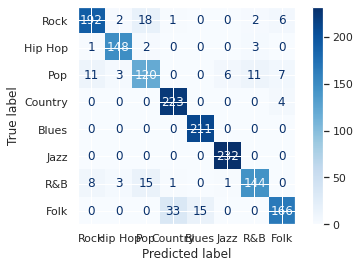

In [ ]:
cm = confusion_matrix(array(y_vali), array(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sorted_dict.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Baseline

In [ ]:
# Make TfIdf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [ ]:
vectors = vectorizer.fit_transform(x_tr)

In [ ]:
print(vectors)

  (0, 8825)	0.024771515857876354
  (0, 1897)	0.029297695265681087
  (0, 20581)	0.02757203041276493
  (0, 8170)	0.018745186242270086
  (0, 17715)	0.027903909630828654
  (0, 17294)	0.01476580462083554
  (0, 21018)	0.013417027328471227
  (0, 20866)	0.018355062396751724
  (0, 2603)	0.0309542124456235
  (0, 20594)	0.024950166071810866
  (0, 18862)	0.013939412528435247
  (0, 3110)	0.03355325446591544
  (0, 4314)	0.036772460727355065
  (0, 1659)	0.026196073333046074
  (0, 11730)	0.06710650893183089
  (0, 18883)	0.01644998838996817
  (0, 6348)	0.014228954781409396
  (0, 14878)	0.014077544134762743
  (0, 11832)	0.027903909630828654
  (0, 16772)	0.026567818314417957
  (0, 18409)	0.03355325446591544
  (0, 20488)	0.019385915828794932
  (0, 4854)	0.017815381588491455
  (0, 13882)	0.02945066175057174
  (0, 15490)	0.021869606909557797
  :	:
  (4038, 2842)	0.13201771937157808
  (4038, 2322)	0.032256101962502406
  (4038, 18883)	0.03202572420894895
  (4038, 640)	0.1115160202009957
  (4038, 18691)	0.0222

In [ ]:
vectors_test = vectorizer.transform(x_val)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=4).fit(vectors, y_tre)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
clf.score(vectors_test, y_vali)

0.5871824480369515

## Third model (+ аудиофичи)

### Data Preprocessing

In [ ]:
audio_feats = ['spotify_danceability',	'spotify_energy',	'spotify_speechiness',	'spotify_valence',	'spotify_acousticness']
feats_train = df_train[audio_feats].to_numpy()
feats_test = df_test[audio_feats].to_numpy()

### Model

В данной модели так же будем использовать 5 аудиофичей.
Данные нормализовывать не будем, они и так находятся в диапазоне [0,1]

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
# InputA - Dense model by fichi's
inputA = Input(shape=(5,))
# inputB - LSTM model
inputB = Input(shape=(maximumlen,))
 
# the first branch operates on the first input
x = Dense(125, activation="relu", activity_regularizer=regularizers.l2(1e-5))(inputA)
x = Dropout(0.15)(x)
x = Dense(256, activation="relu")(inputA)
x = Dropout(0.3)(x)
x = Dense(NUM_OF_CAT, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
 
y = Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)(inputB)
y = Bidirectional(LSTM(256,return_sequences=True,dropout=0.05, activity_regularizer=tf.keras.regularizers.l2(0.01)))(y)
y = GlobalMaxPooling1D()(y)
y = Dense(256, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(5e-6))(y)
y = Dropout(0.15)(y)
y = Dense(128, activation="relu", activity_regularizer=regularizers.l2(5e-6))(y)
y = Dense(NUM_OF_CAT,activation='relu', activity_regularizer=regularizers.l2(5e-6))(y)
y = Model(inputs=inputB, outputs=y)
 
combined = concatenate([x.output, y.output])
 
z = Dense(NUM_OF_CAT,activation='softmax')(combined)
#z = Dense(128, activation="relu")(combined)
#z = Dense(NUM_OF_CAT,activation='softmax')(z)
 
model = Model(inputs=[x.input, y.input], outputs=z)

optimizer = keras.optimizers.Adam(lr=0.00003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  
mc=ModelCheckpoint('best_model_f.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)
print(model.summary())  

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1077)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1077, 300)    7026300     ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 1077, 512)   1140736     ['embedding_4[0][0]']            
 )                                                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Model traning

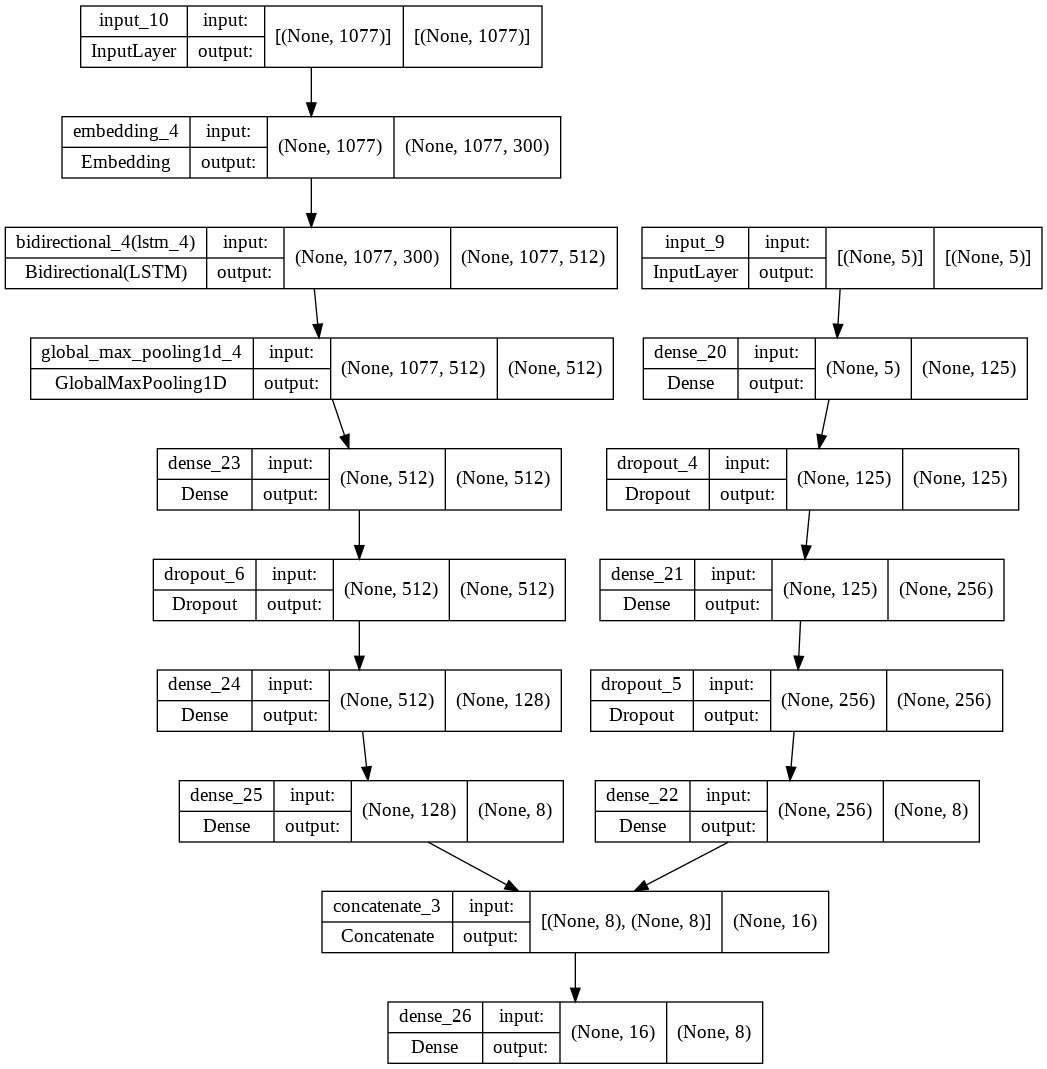

In [ ]:
# Выведем наш граф модели
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
history = model.fit( [np.array(feats_train), np.array(x_tr_seq)], np.array(y_tr), batch_size=32, shuffle=True, epochs=40,callbacks=[lr_scheduler, es, mc], validation_data=([np.array(feats_test), np.array(x_val_seq)],np.array(y_val)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
174/174 [==============================] - ETA: 0s - loss: 5.9540 - acc: 0.1634 - f1: 0.0000e+00
Epoch 1: val_acc improved from -inf to 0.21746, saving model to best_model_f.h5
174/174 [==============================] - 150s 641ms/step - loss: 5.9540 - acc: 0.1634 - f1: 0.0000e+00 - val_loss: 3.7700 - val_acc: 0.2175 - val_f1: 0.0000e+00
Epoch 2/40
174/174 [==============================] - ETA: 0s - loss: 3.4176 - acc: 0.2209 - f1: 0.0000e+00
Epoch 2: val_acc improved from 0.21746 to 0.26658, saving model to best_model_f.h5
174/174 [==============================] - 110s 635ms/step - loss: 3.4176 - acc: 0.2209 - f1: 0.0000e+00 - val_loss: 2.9336 - val_acc: 0.2666 - val_f1: 0.0000e+00
Epoch 3/40
174/174 [==============================] - ETA: 0s - loss: 2.8018 - acc: 0.2882 - f1: 0.0017
Epoch 3: val_acc improved from 0.26658 to 0.32704, saving model to best_model_f.h5
174/174 [==============================] - 110s 633ms/step - loss: 2.8018 - acc: 0.2882 - f1: 0.0017 - val_l

### Графики

In [ ]:
from matplotlib import pyplot as plt

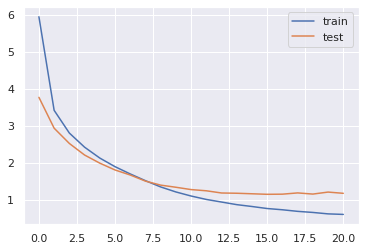

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

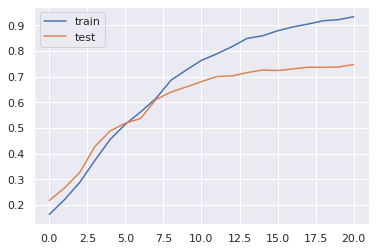

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

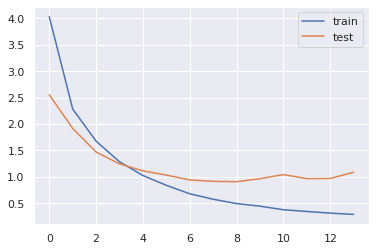

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

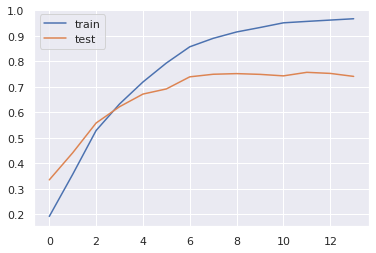

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Confusion matrix of model

In [ ]:
# [np.array(feats_test), np.array(x_val_seq)],np.array(y_val)
predicted = model.predict([np.array(feats_test), np.array(x_val_seq)],workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y_pred = np.argmax(predicted, axis=1)

In [ ]:
genres_with_num

{'Blues': 4,
 'Country': 5,
 'Folk': 2,
 'Hip Hop': 3,
 'Jazz': 6,
 'Pop': 0,
 'R&B': 7,
 'Rock': 1}

[[ 94  85  29   1  14  35   4  40]
 [ 46 214  18   2   4  27   1  21]
 [  0   0 288   0  14  17   0   0]
 [  7  14   0 191   0  20   1   6]
 [  0   0   4   0 269   0   0   0]
 [ 10   0  30   0   0 225   0   0]
 [  0   0   0   0   0   0 322   0]
 [ 74  43   8   7   3  27   6 161]]


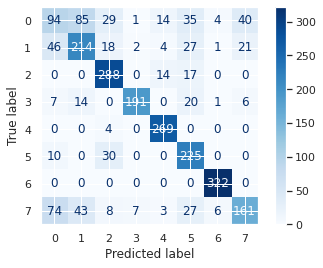

In [ ]:
cm = confusion_matrix(array(y_vali), array(y_pred))
print(cm)
#labels = list(genres_with_num)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


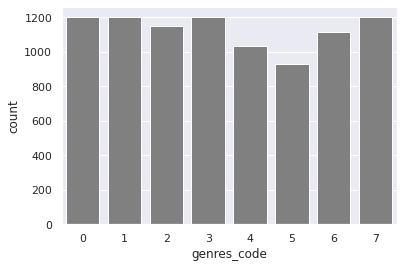

In [ ]:
import seaborn as sns
sns.set()

sns.countplot(res['genres_code'], color='gray')

## Модель только с аудиофичами

### Model

In [ ]:
audio_feats = ['spotify_danceability',	'spotify_energy',	'spotify_speechiness',	'spotify_valence',	'spotify_acousticness']
feats_train = df_train[audio_feats].to_numpy()
feats_test = df_test[audio_feats].to_numpy()

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
model=Sequential()

#Embedding layer
model.add(Input(shape=(5,))) 

#Dense Layer
model.add(Dense(125,activation='relu', activity_regularizer=regularizers.l1(1e-7)))
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), activity_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.4))
model.add(Dense(1024,activation='relu', activity_regularizer=regularizers.l2(1e-7)))
model.add(Dropout(0.25))
model.add(Dense(2048,activation='relu', activity_regularizer=regularizers.l2(1e-7)))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu', activity_regularizer=regularizers.l2(1e-7)))
model.add(Dropout(0.15))
#model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.15))
model.add(Dense(NUM_OF_CAT,activation='softmax')) 
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adam(lr=0.00003)
# В случае 'binary_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  


print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 125)               750       
                                                                 
 dropout_13 (Dropout)        (None, 125)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               64512     
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 2048)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit( np.array(feats_train), np.array(y_tr), batch_size=16, shuffle=True, epochs=600,callbacks=[ mc], validation_data=(np.array(feats_test),np.array(y_val)))

Epoch 1/600
349/349 [==============================] - ETA: 0s - loss: 2.0335 - acc: 0.1999 - f1: 0.0000e+00
Epoch 1: val_acc improved from -inf to 0.25262, saving model to best_model.h5
349/349 [==============================] - 8s 16ms/step - loss: 2.0335 - acc: 0.1999 - f1: 0.0000e+00 - val_loss: 1.8922 - val_acc: 0.2526 - val_f1: 0.0000e+00
Epoch 2/600
347/349 [============================>.] - ETA: 0s - loss: 1.8182 - acc: 0.2794 - f1: 3.3904e-04
Epoch 2: val_acc improved from 0.25262 to 0.29409, saving model to best_model.h5
349/349 [==============================] - 4s 11ms/step - loss: 1.8185 - acc: 0.2796 - f1: 6.7420e-04 - val_loss: 1.7568 - val_acc: 0.2941 - val_f1: 7.8431e-04
Epoch 3/600
346/349 [============================>.] - ETA: 0s - loss: 1.7479 - acc: 0.3091 - f1: 0.0293
Epoch 3: val_acc improved from 0.29409 to 0.34981, saving model to best_model.h5
349/349 [==============================] - 4s 11ms/step - loss: 1.7484 - acc: 0.3090 - f1: 0.0290 - val_loss: 1.6831 

### Графики

In [ ]:
from matplotlib import pyplot as plt

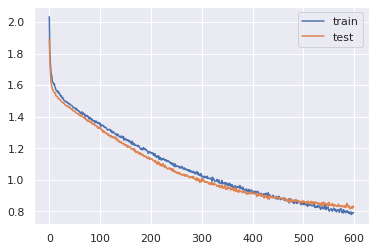

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

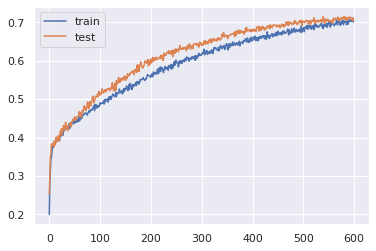

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Confusion matrix of third model

In [ ]:
# [np.array(feats_test), np.array(x_val_seq)],np.array(y_val)
predicted = model.predict(np.array(feats_test),workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y_pred = np.argmax(predicted, axis=1)

In [ ]:
dict1 = genres_with_num
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

print(sorted_dict) # {1: 1, 3: 4, 2: 9}
sorted_dict.keys()

{'Rock': 0, 'R&B': 1, 'Hip Hop': 2, 'Pop': 3, 'Country': 4, 'Folk': 5, 'Jazz': 6, 'Blues': 7}


In [ ]:
sorted_dict.keys()

dict_keys(['Rock', 'R&B', 'Hip Hop', 'Pop', 'Country', 'Folk', 'Jazz', 'Blues'])

In [ ]:
genres_with_num

{'Blues': 7,
 'Country': 4,
 'Folk': 5,
 'Hip Hop': 2,
 'Jazz': 6,
 'Pop': 3,
 'R&B': 1,
 'Rock': 0}

[[178  30   6  31  43  30   9   5]
 [ 43  82  24  26  44  16  14   9]
 [ 13  16 174  13   7   1   3   3]
 [ 48  37  12  54  33  27  29   5]
 [  7   0   0   8 298  22   3   2]
 [  0   0   0   0  45 242  14  19]
 [  0   0   0   0   0   0 345   0]
 [  0   0   0   0   0   0   0 317]]


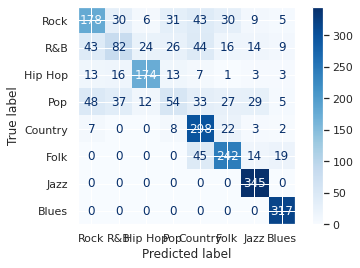

In [ ]:
cm = confusion_matrix(array(y_vali), array(y_pred))
print(cm)
#labels = list(genres_with_num)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted_dict.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


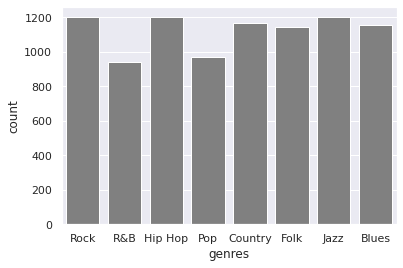

In [ ]:
import seaborn as sns
sns.set()

sns.countplot(res['genres'], color='gray')

## Облегчённая модель с аудиофичами

### Data Preprocessing

In [ ]:
audio_feats = ['spotify_danceability',	'spotify_energy',	'spotify_speechiness',	'spotify_valence',	'spotify_acousticness']
feats_train = df_train[audio_feats].to_numpy()
feats_test = df_test[audio_feats].to_numpy()

### Model

In [ ]:
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
# InputA - Dense model by fichi's
inputA = Input(shape=(5,))
# inputB - LSTM model
inputB = Input(shape=(maximumlen,))
 
# the first branch operates on the first input

x = Dense(125,activation='relu', activity_regularizer=regularizers.l1(1e-7))(inputA)
x = Dropout(0.35)(x)
x = Dense(1024,activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), activity_regularizer=regularizers.l2(1e-7))(x)
x = Dense(NUM_OF_CAT, activation="tanh")(x)
x = Model(inputs=inputA, outputs=x)
 
y = Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)(inputB)
y = Bidirectional(LSTM(256,return_sequences=True,dropout=0.05, activity_regularizer=tf.keras.regularizers.l2(1e-5)))(y)
y = GlobalMaxPooling1D()(y)
y = Dense(256, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-4))(y)
y = Dense(NUM_OF_CAT,activation='tanh', activity_regularizer=regularizers.l2(1e-4))(y)
y = Model(inputs=inputB, outputs=y)
 
combined = concatenate([x.output, y.output])
 
z = Dense(NUM_OF_CAT,activation='softmax')(combined)
#z = Dense(128, activation="relu")(combined)
#z = Dense(NUM_OF_CAT,activation='softmax')(z)
 
model = Model(inputs=[x.input, y.input], outputs=z)

optimizer = keras.optimizers.Adam(lr=ё)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)  
mc=ModelCheckpoint('best_model_f.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)
print(model.summary())  

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1077)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 1077, 300)    6433800     ['input_8[0][0]']                
                                                                                                  
 dense_59 (Dense)               (None, 125)          750         ['input_7[0][0]']                
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Model traning

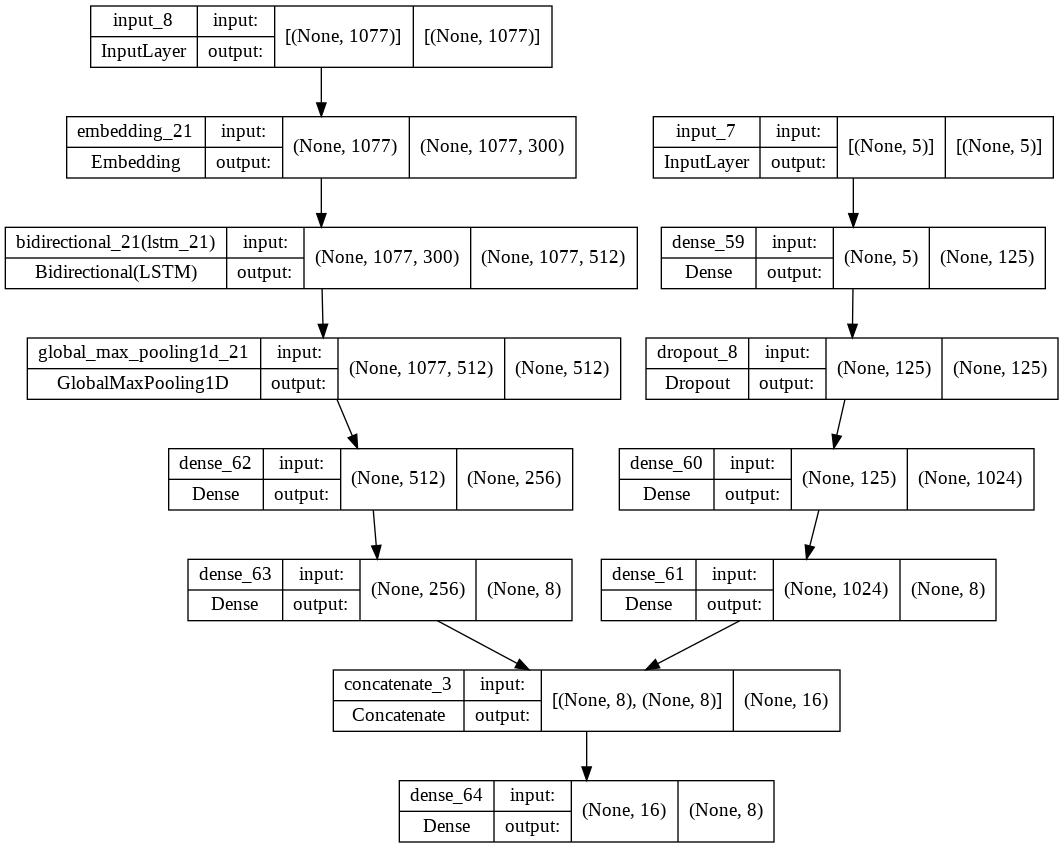

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.00035)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["acc", f1]) 
history = model.fit( [np.array(feats_train), np.array(x_tr_seq)], np.array(y_tr), batch_size=128, shuffle=True, epochs=400,callbacks=[ es, mc], validation_data=([np.array(feats_test), np.array(x_val_seq)],np.array(y_val)))

Epoch 1/400


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/44 [==============================] - ETA: 0s - loss: 1.9864 - acc: 0.3351 - f1: 0.0000e+00
Epoch 1: val_acc improved from -inf to 0.50817, saving model to best_model_f.h5
44/44 [==============================] - 77s 2s/step - loss: 1.9864 - acc: 0.3351 - f1: 0.0000e+00 - val_loss: 1.7311 - val_acc: 0.5082 - val_f1: 0.0000e+00
Epoch 2/400
44/44 [==============================] - ETA: 0s - loss: 1.6054 - acc: 0.5409 - f1: 0.1279
Epoch 2: val_acc improved from 0.50817 to 0.61081, saving model to best_model_f.h5
44/44 [==============================] - 71s 2s/step - loss: 1.6054 - acc: 0.5409 - f1: 0.1279 - val_loss: 1.4580 - val_acc: 0.6108 - val_f1: 0.2989
Epoch 3/400
44/44 [==============================] - ETA: 0s - loss: 1.3795 - acc: 0.6249 - f1: 0.3696
Epoch 3: val_acc improved from 0.61081 to 0.66234, saving model to best_model_f.h5
44/44 [==============================] - 73s 2s/step - loss: 1.3795 - acc: 0.6249 - f1: 0.3696 - val_loss: 1.2881 - val_acc: 0.6623 - val_f1: 0.496

### Графики

In [ ]:
from matplotlib import pyplot as plt

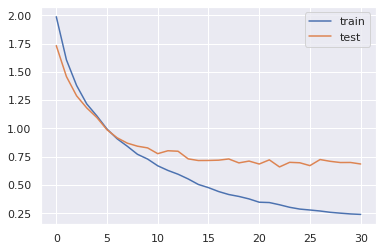

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

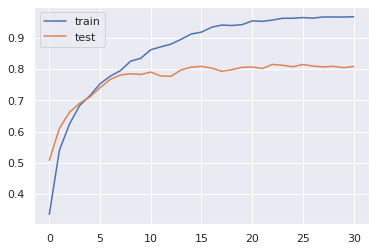

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

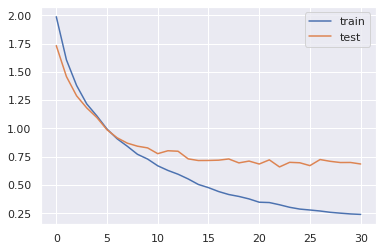

In [ ]:
# plot loss training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

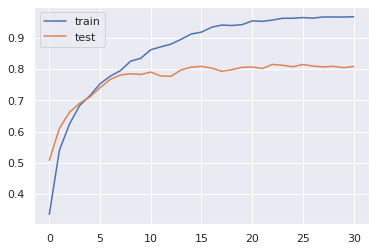

In [ ]:
# plot accuracy training history

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Confusion matrix of model

In [ ]:
# [np.array(feats_test), np.array(x_val_seq)],np.array(y_val)
predicted = model.predict([np.array(feats_test), np.array(x_val_seq)],workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y_pred = np.argmax(predicted, axis=1)

In [ ]:
genres_with_num

{'Blues': 1,
 'Country': 2,
 'Folk': 4,
 'Hip Hop': 7,
 'Jazz': 3,
 'Pop': 6,
 'R&B': 5,
 'Rock': 0}

[[213   4   7   2   7  24  71   4]
 [  0 303   0   0  14   0   0   0]
 [  0   0 320   0  20   0   0   0]
 [  0   0   0 345   0   0   0   0]
 [  0  12  32   0 276   0   0   0]
 [ 31   3   5   1   2 158  50   8]
 [ 59   8  12   4  14  39 103   6]
 [  2   1   3   1   0   8   3 212]]


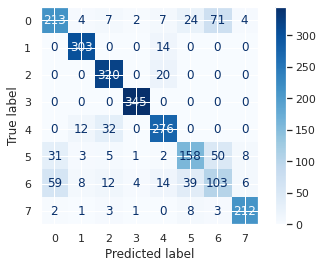

In [ ]:
cm = confusion_matrix(array(y_vali), array(y_pred))
print(cm)
#labels = list(genres_with_num)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


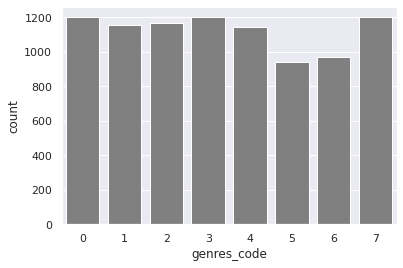

In [ ]:
import seaborn as sns
sns.set()

sns.countplot(res['genres_code'], color='gray')

## BERT

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle

from transformers import BertTokenizer, TFBertModel, BertConfig



In [ ]:
#from transformers import BertTokenizerFast, BertForSequenceClassification
#tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)


from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=NUM_OF_CAT)

In [ ]:
input_ids=[]
attention_masks=[]

for sent in x_tr:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =400,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(y_tre)

In [ ]:
len(input_ids),len(attention_masks),len(labels)

(6364, 6364, 6364)

In [ ]:
print('Preparing the pickle file.....')

pickle_inp_path='./bert_inp.pkl'
pickle_mask_path='./bert_mask.pkl'
pickle_label_path='./bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

 

Preparing the pickle file.....
Pickle files saved as  ./bert_inp.pkl ./bert_mask.pkl ./bert_label.pkl
Loading the saved pickle files..
Input shape (6364, 400) Attention mask shape (6364, 400) Input label shape (6364,)


In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


Train inp shape (5091, 400) Val input shape (1273, 400)
Train label shape (5091,) Val label shape (1273,)
Train attention mask shape (5091, 400) Val attention mask shape (1273, 400)


In [ ]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
 

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6152      
                                                                 
Total params: 109,488,392
Trainable params: 109,488,392
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=12,epochs=3,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks) 

Epoch 1/3
425/425 [==============================] - 1049s 2s/step - loss: 1.1218 - accuracy: 0.6162 - val_loss: 0.7987 - val_accuracy: 0.7258
Epoch 2/3
425/425 [==============================] - 979s 2s/step - loss: 0.5536 - accuracy: 0.8055 - val_loss: 0.5945 - val_accuracy: 0.7777
Epoch 3/3
425/425 [==============================] - 979s 2s/step - loss: 0.3411 - accuracy: 0.8790 - val_loss: 0.4930 - val_accuracy: 0.8099


In [ ]:
preds = bert_model.predict([val_inp,val_mask],batch_size=16)

In [ ]:
dict1 = genres_with_num
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

print(sorted_dict) # {1: 1, 3: 4, 2: 9}


{'Blues': 0, 'Hip Hop': 1, 'Jazz': 2, 'R&B': 3, 'Folk': 4, 'Rock': 5, 'Pop': 6, 'Country': 7}


dict_keys(['Blues', 'Hip Hop', 'Jazz', 'R&B', 'Folk', 'Rock', 'Pop', 'Country'])

In [ ]:
a = preds

pred_labels = np.argmax(a["logits"], axis=1)
print(pred_labels)
f1 = f1_score(val_label,pred_labels, average=None)
print('F1 score',f1)

print(classification_report(val_label,pred_labels ,target_names=list(sorted_dict.keys())))


[0 2 0 ... 3 4 5]
F1 score [0.96341463 0.93103448 1.         0.6459144  0.87573964 0.6259542
 0.49438202 0.88828338]
              precision    recall  f1-score   support

       Blues       0.93      0.99      0.96       159
     Hip Hop       0.99      0.88      0.93       123
        Jazz       1.00      1.00      1.00       182
         R&B       0.72      0.59      0.65       141
        Folk       0.94      0.82      0.88       181
        Rock       0.58      0.68      0.63       182
         Pop       0.52      0.47      0.49       140
     Country       0.81      0.99      0.89       165

    accuracy                           0.81      1273
   macro avg       0.81      0.80      0.80      1273
weighted avg       0.81      0.81      0.81      1273



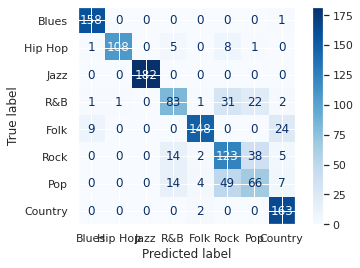

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(val_label, pred_labels)

#labels = list(genres_with_num)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sorted_dict.keys()))
disp.plot(cmap=plt.cm.Blues)

plt.show()

## LSTM

### Model

In [ ]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from keras.layers import Bidirectional

model=Sequential()

#Embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

#LSTM layer
model.add(Bidirectional(LSTM(512,return_sequences=True,dropout=0.05)))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(NUM_OF_CAT,activation='sigmoid')) 

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['binary_accuracy', f1]) 
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  
mc1 =ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True,verbose=1)  


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1093, 300)         9546300   
                                                                 
 bidirectional (Bidirectiona  (None, 1093, 1024)       3330048   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


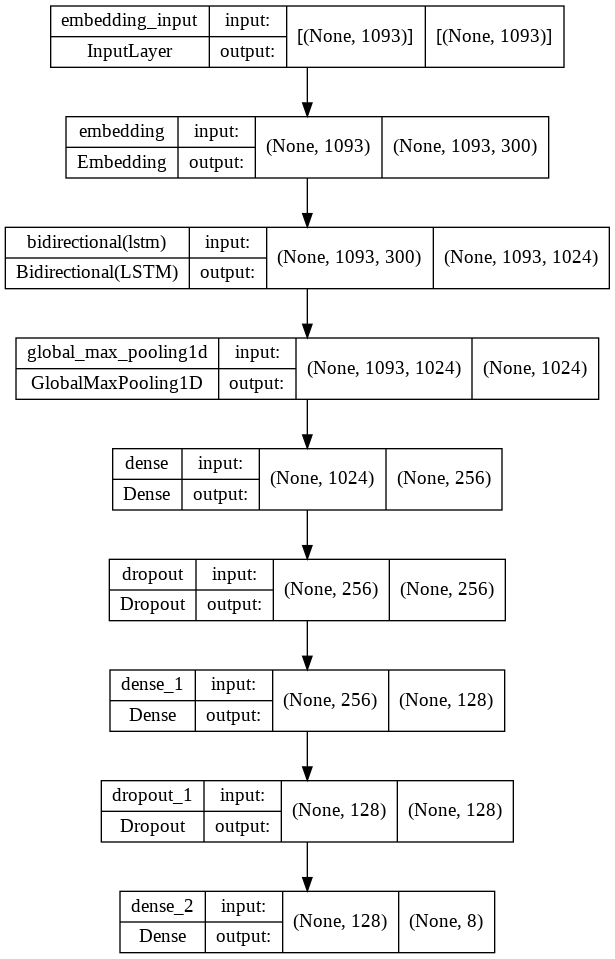

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    else:
        return lr * tf.math.exp(-0.3)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit( np.array(x_tr_seq), np.array(y_tr), batch_size=32, shuffle=True, epochs=75,callbacks=[lr_scheduler, es1, mc1], validation_data=(np.array(x_val_seq),np.array(y_val)))

Epoch 1/75
260/260 [==============================] - ETA: 0s - loss: 0.4272 - binary_accuracy: 0.7987 - f1: 0.3176
Epoch 1: val_binary_accuracy improved from -inf to 0.83406, saving model to best_model.h5
260/260 [==============================] - 271s 1s/step - loss: 0.4272 - binary_accuracy: 0.7987 - f1: 0.3176 - val_loss: 0.3525 - val_binary_accuracy: 0.8341 - val_f1: 0.4842 - lr: 1.0000e-04
Epoch 2/75
260/260 [==============================] - ETA: 0s - loss: 0.3616 - binary_accuracy: 0.8304 - f1: 0.4659
Epoch 2: val_binary_accuracy improved from 0.83406 to 0.85076, saving model to best_model.h5
260/260 [==============================] - 260s 999ms/step - loss: 0.3616 - binary_accuracy: 0.8304 - f1: 0.4659 - val_loss: 0.3228 - val_binary_accuracy: 0.8508 - val_f1: 0.5416 - lr: 1.0000e-04
Epoch 3/75
260/260 [==============================] - ETA: 0s - loss: 0.3189 - binary_accuracy: 0.8541 - f1: 0.5590
Epoch 3: val_binary_accuracy improved from 0.85076 to 0.87615, saving model to b

KeyboardInterrupt: ignored

### Confusion matrix of second model

In [ ]:
predicted = model.predict(np.array(x_val_seq),workers=6, use_multiprocessing=True)

In [ ]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dict1 = genres_with_num
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

print(sorted_dict) # {1: 1, 3: 4, 2: 9}


{'Hip Hop': 0, 'Folk': 1, 'Jazz': 2, 'Country': 3, 'Blues': 4, 'Pop': 5, 'Rock': 6, 'R&B': 7}


In [ ]:
predicted = (predicted > 0.3)

In [ ]:
predicted

array([[False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False,  True, ...,  True, False,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [ ]:
f1 = f1_score(y_val,predicted, average=None)
print('F1 score',f1)

print(classification_report(y_val,predicted,target_names=list(sorted_dict.keys())))

F1 score [0.87112561 0.56652361 0.70559611 0.78640777 0.69473684 0.78534523
 0.80720093 0.77968526]
              precision    recall  f1-score   support

     Hip Hop       0.85      0.89      0.87       299
        Folk       0.56      0.57      0.57       115
        Jazz       0.67      0.74      0.71       195
     Country       0.76      0.82      0.79        99
       Blues       0.85      0.59      0.69        56
         Pop       0.69      0.90      0.79       926
        Rock       0.74      0.89      0.81       782
         R&B       0.77      0.79      0.78       688

   micro avg       0.73      0.84      0.78      3160
   macro avg       0.74      0.78      0.75      3160
weighted avg       0.73      0.84      0.78      3160
 samples avg       0.77      0.86      0.79      3160



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
a = (y_val == 1)

In [ ]:
from numpy import array
cm = confusion_matrix(array(a), array(predicted))
print(cm)

[[[1727   47]
  [  32  267]]

 [[1906   52]
  [  49   66]]

 [[1807   71]
  [  50  145]]

 [[1948   26]
  [  18   81]]

 [[2011    6]
  [  23   33]]

 [[ 780  367]
  [  90  836]]

 [[1046  245]
  [  87  695]]

 [[1220  165]
  [ 143  545]]]
